In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [2]:
# Ruta de estudio de test (el estudio esta compuesto de varios archivos .dcm, cada archivo es un corte)
new_study_dir = './Imagenes_Finales/Test/I364087'

In [3]:
# Función para cargar y normalizar el volumen DICOM
def load_dicom_volume(dicom_dir):
    dicom_files = [f for f in os.listdir(dicom_dir) if f.endswith(".dcm")]
    dicom_data = [pydicom.dcmread(os.path.join(dicom_dir, f)) for f in dicom_files]

    # Ordenar por InstanceNumber
    dicom_data.sort(key=lambda dcm: int(dcm.InstanceNumber))  

    # Obtener dimensiones del volumen
    shape = dicom_data[0].pixel_array.shape
    volume = np.zeros((len(dicom_data), shape[0], shape[1]), dtype=np.float32)

    # Llenar el volumen con los datos de cada corte
    for i, dcm in enumerate(dicom_data):
        volume[i, :, :] = dcm.pixel_array

    # Normalizar a rango [0,1]
    volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume) + 1e-7)
    
    return volume

In [4]:
# Función para generar baja resolución (LR)
def low_res_volume(volume, factor=0.5):
    d, h, w = volume.shape
    low_res = np.zeros_like(volume)
    
    for i in range(d):
        downsampled = cv2.resize(volume[i], (int(w * factor), int(h * factor)), interpolation=cv2.INTER_AREA)
        upsampled = cv2.resize(downsampled, (w, h), interpolation=cv2.INTER_LINEAR)
        low_res[i] = upsampled
    
    return low_res

In [5]:
# Función para dividir volumen en patches 3D
def extract_patches(volume, patch_size=(64, 64, 64), stride=32):
    d, h, w = volume.shape
    patches = []
    indices = []
    
    for z in range(0, d - patch_size[0] + 1, stride):
        for y in range(0, h - patch_size[1] + 1, stride):
            for x in range(0, w - patch_size[2] + 1, stride):
                patches.append(volume[z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]])
                indices.append((z, y, x))
    
    return patches, indices

In [6]:
# Función para reconstruir el volumen a partir de los patches
def reconstruct_volume(patches, indices, shape, patch_size=(64, 64, 64), stride=32):
    d, h, w = shape
    reconstructed = np.zeros(shape, dtype=np.float32)
    count_map = np.zeros(shape, dtype=np.float32)
    
    for (patch, (z, y, x)) in zip(patches, indices):
        reconstructed[z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]] += patch
        count_map[z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]] += 1
    
    return reconstructed / (count_map + 1e-7)  # Evitar división por cero

In [7]:
# Modelo EDSR3D
class ResidualBlock3D(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return x + self.block(x)

class EDSR3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_blocks=4, base_channels=32):
        super().__init__()
        self.head = nn.Conv3d(in_channels, base_channels, kernel_size=3, padding=1)
        self.body = nn.Sequential(*[ResidualBlock3D(base_channels) for _ in range(num_blocks)])
        self.tail = nn.Conv3d(base_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.head(x)
        res = self.body(x)
        return self.tail(x + res)

In [ ]:
# Cargar el modelo entrenado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EDSR3D().to(device)
model.load_state_dict(torch.load("EDSRD3D_final.pth", map_location=device))
model.eval()

In [9]:
# Cargar y procesar el nuevo estudio
hr_volume = load_dicom_volume(new_study_dir)
lr_volume = low_res_volume(hr_volume)

In [10]:
# Extraer patches de la imagen LR
lr_patches, indices = extract_patches(lr_volume)

In [11]:
# Convertir a tensores y procesar con el modelo
pred_patches = []
for patch in lr_patches:
    patch_tensor = torch.tensor(patch, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1,1,D,H,W)
    with torch.no_grad():
        pred_patch = model(patch_tensor).cpu().squeeze().numpy()
    pred_patches.append(pred_patch)

In [12]:
# Reconstruir el volumen HR generado
sr_volume = reconstruct_volume(pred_patches, indices, hr_volume.shape)

In [13]:
# Calcular métricas PSNR, SSIM y MSE
psnr_value = psnr(hr_volume, sr_volume, data_range=1)
ssim_value = ssim(hr_volume, sr_volume, data_range=1, channel_axis=0)
mse_value = np.mean((hr_volume - sr_volume) ** 2)
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")
print(f"MSE: {mse_value:.6f}")

PSNR: 38.26 dB
SSIM: 0.9697
MSE: 0.000149


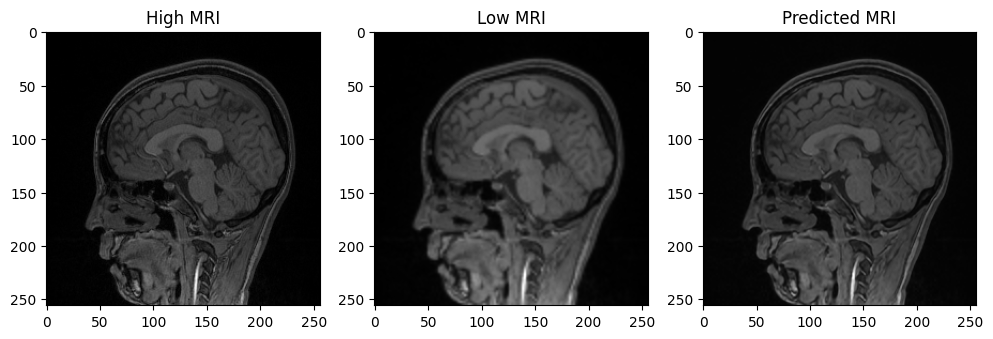

In [14]:
# Visualizar una slice del volumen original y el generado
slice_idx = hr_volume.shape[0] // 2  # Tomar la mitad del volumen
#slice_idx = 25  # Cambia este valor según el tamaño del volumen
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(hr_volume[slice_idx], cmap="gray")
plt.title("High MRI")
plt.axis("on")

plt.subplot(1, 3, 2)
plt.imshow(lr_volume[slice_idx], cmap="gray")
plt.title("Low MRI")
plt.axis("on")

plt.subplot(1, 3, 3)
plt.imshow(sr_volume[slice_idx], cmap="gray")
plt.title("Predicted MRI")
plt.axis("on")

# Guardar la imagen generada antes de plt.show()
#plt.savefig("resultado_EDSR3D.png", dpi=300, bbox_inches="tight")

plt.show()